In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [26]:
df = pd.read_csv('data/cleaned_rounds_data_with_stats.csv')
df.head()

,round_winner,team_1_position,team_1_win_percentage,team_2_position,team_2_win_percentage,player_1_team_name,player_1_name,player_1_rating,player_1_kills_per_round,player_1_headshots,...,player_10_CZ75-Auto,player_10_Desert Eagle,player_10_R8 Revolver,player_10_Dual Berettas,player_10_Smoke Grenade,player_10_High Explosive Grenade,player_10_Flashbang,player_10_Incendiary Grenade,player_10_Molotov,player_10_Decoy Grenade
0,1,30,58.1,5,66.7,G2 Esports,NiKo,1.18,0.72,51.8,...,0,0,0,0,1,0,1,1,0,0
1,1,30,58.1,5,66.7,G2 Esports,NiKo,1.18,0.72,51.8,...,0,0,0,0,1,1,1,1,0,0
2,0,30,58.1,5,66.7,G2 Esports,NiKo,1.18,0.72,51.8,...,0,0,0,0,1,1,0,1,0,0
3,1,30,58.1,5,66.7,G2 Esports,NiKo,1.18,0.72,51.8,...,0,0,0,0,1,1,0,1,0,0
4,1,30,58.1,5,66.7,G2 Esports,NiKo,1.18,0.72,51.8,...,0,0,0,0,1,1,1,1,0,0


In [27]:
df = df.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
df.head()

,round_winner,team_1_position,team_1_win_percentage,team_2_position,team_2_win_percentage,player_1_rating,player_1_kills_per_round,player_1_headshots,player_1_deaths_per_round,player_1_rounds_contributed,...,player_10_CZ75-Auto,player_10_Desert Eagle,player_10_R8 Revolver,player_10_Dual Berettas,player_10_Smoke Grenade,player_10_High Explosive Grenade,player_10_Flashbang,player_10_Incendiary Grenade,player_10_Molotov,player_10_Decoy Grenade
0,1,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,...,0,0,0,0,1,0,1,1,0,0
1,1,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,...,0,0,0,0,1,1,1,1,0,0
2,0,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,...,0,0,0,0,1,1,0,1,0,0
3,1,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,...,0,0,0,0,1,1,0,1,0,0
4,1,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,...,0,0,0,0,1,1,1,1,0,0


In [28]:
df['round_winner'].count()

11686

In [5]:
def sigmoid(z):
    """Numerically stable sigmoid function."""
    z = np.clip(z, -500, 500)  # Limit z to avoid overflow
    return np.where(z >= 0,
                    1 / (1 + np.exp(-z)),
                    np.exp(z) / (1 + np.exp(z)))

In [6]:
def cross_entropy(y, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

In [7]:
def compute_gradients(X, y, y_pred):
    diff = y_pred - y
    return np.dot(X.T, diff) / len(y)

In [8]:
def initialize_weights(size):
    std_dev = np.sqrt(2 / (size + 1))
    return np.random.randn(size) * std_dev

In [9]:
def logistic_regression(X, y, lr, epochs, e=1e-6):
    w = initialize_weights(X.shape[1])
    losses = []
    for epoch in range(epochs):
        z = np.dot(X, w)
        y_pred = sigmoid(z)
        loss = cross_entropy(y, y_pred)
        gradients = compute_gradients(X, y, y_pred)
        w -= lr * gradients
        new_loss = cross_entropy(y, sigmoid(np.dot(X, w)))
        losses.append(new_loss)
        if epoch % 250 == 0:
            print(f'Epoch {epoch}, loss {loss}')
        if np.abs(new_loss - loss) < e:
            print(np.abs(new_loss - loss))
            print(f'Converged at epoch {epoch}')
            break
    return w, losses

In [10]:
def predict_probabilities(X, w):
    z = np.dot(X, w)
    probabilities = sigmoid(z)
    return probabilities

In [11]:
def predict(X, w, threshold=0.5):
    probabilities = predict_probabilities(X, w)
    return (probabilities >= threshold).astype(int)

In [29]:
X = df.drop(['round_winner'], axis=1)
X.head()

,team_1_position,team_1_win_percentage,team_2_position,team_2_win_percentage,player_1_rating,player_1_kills_per_round,player_1_headshots,player_1_deaths_per_round,player_1_rounds_contributed,player_1_team_num,...,player_10_CZ75-Auto,player_10_Desert Eagle,player_10_R8 Revolver,player_10_Dual Berettas,player_10_Smoke Grenade,player_10_High Explosive Grenade,player_10_Flashbang,player_10_Incendiary Grenade,player_10_Molotov,player_10_Decoy Grenade
0,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,0,...,0,0,0,0,1,0,1,1,0,0
1,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,0,...,0,0,0,0,1,1,1,1,0,0
2,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,0,...,0,0,0,0,1,1,0,1,0,0
3,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,0,...,0,0,0,0,1,1,0,1,0,0
4,30,58.1,5,66.7,1.18,0.72,51.8,0.64,73.5,0,...,0,0,0,0,1,1,1,1,0,0


In [30]:
y = df['round_winner']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [32]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

BEST PARAMETERS FOR ROUNDS DATA WITH STATS

In [33]:
lr = 0.01
epochs = 4000

In [34]:
w, losses = logistic_regression(X_train, y_train, lr, epochs)

Epoch 0, loss 0.9477900845268937
Epoch 250, loss 0.5571429293493674
Epoch 500, loss 0.5135023834224028
Epoch 750, loss 0.4990994860354285
Epoch 1000, loss 0.4922792022028064
Epoch 1250, loss 0.488588208293971
Epoch 1500, loss 0.48637465323676643
Epoch 1750, loss 0.48491683905522126
Epoch 2000, loss 0.48388971307593626
Epoch 2250, loss 0.4831283046826162
Epoch 2500, loss 0.48254103462590825
Epoch 2750, loss 0.482073597933883
Epoch 3000, loss 0.481692018088008
Epoch 3250, loss 0.4813740460454239
9.998290324553238e-07
Converged at epoch 3494


In [35]:
print(f"Weights: {w}")

Weights: [ 1.63085566e-02 -3.69371134e-02 -2.90667406e-03 -8.08476155e-03
 -3.05651984e-02  5.10391440e-02 -5.60707862e-02  1.59388563e-02
 -1.94420679e-02  2.57611368e-02  1.94791304e-03 -2.55133001e-02
  1.61070153e-01  6.69292403e-02  4.26886969e-02 -5.74809860e-03
  5.68469959e-03 -3.21882252e-02 -7.36669422e-02  3.56836325e-02
 -1.14643356e-01 -3.32594565e-02 -3.52653586e-02  5.18127182e-02
 -1.05579152e-01  4.49700397e-02 -5.83270043e-02 -7.41951833e-02
  4.89519841e-02  1.08655246e-02 -5.41387954e-03 -5.31312911e-02
  4.43843616e-02 -1.10506380e-01 -4.98166272e-02 -5.11803955e-02
 -6.33912233e-02 -1.43009998e-02 -1.78367643e-01  1.02586000e-01
 -3.23594681e-02 -2.62873194e-03  8.13474294e-02 -3.50317626e-02
 -1.47835760e-02  1.47148122e-02 -1.26042100e-02 -3.09952684e-02
 -1.48946891e-02  4.49546039e-02 -4.70507041e-02 -6.83578672e-02
 -1.95474601e-02  1.28016930e-01 -1.94823666e-01 -6.26835556e-02
 -4.25432661e-02 -2.15967255e-02  7.85598695e-02 -8.72457628e-02
  3.94806023e-02

In [36]:
y_pred = predict(X_test, w)
y_prob = predict_probabilities(X_test, w)

In [37]:
print(classification_report(y_test, y_pred))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(confusion_matrix, index=['Actual Negative', 'Actual Positive'],
                              columns=['Predicted Negative', 'Predicted Positive'])
print(conf_matrix_df)

              precision    recall  f1-score   support

           0       0.75      0.74      0.74      1864
           1       0.76      0.77      0.76      1993

    accuracy                           0.75      3857
   macro avg       0.75      0.75      0.75      3857
weighted avg       0.75      0.75      0.75      3857

                 Predicted Negative  Predicted Positive
Actual Negative                1375                 489
Actual Positive                 456                1537


In [23]:
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC-AUC Score: {roc_auc}')

ROC-AUC Score: 0.8168797335739466


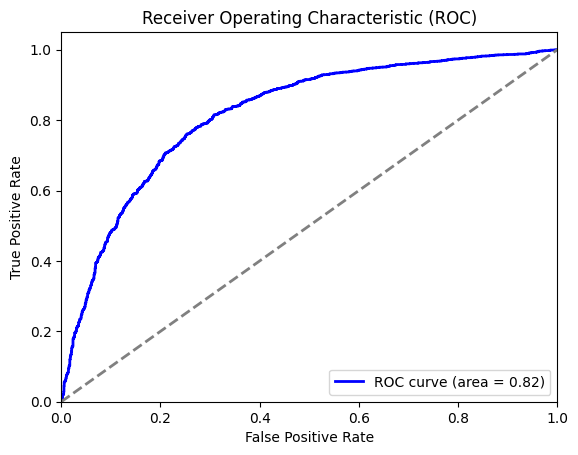

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()